In [14]:
import numpy as np
import skimage
import scipy.io
import pydicom
import os
import sys
import nibabel as nb
import deepbrain
import pandas as pd
import datetime
from pylab import *
import ants

In [2]:
#filesystem for the package
cur_path = os.getcwd()
print("Current Working Directory: "+ cur_path)
try:
    os.makedirs(cur_path+'/params')
    os.makedirs(cur_path+'/visuals/3d_vtk')
    os.makedirs(cur_path+'/visuals/stills_2d')
    os.makedirs(cur_path+'/output')
    os.makedirs(cur_path+'/datasets')
    os.makedirs(cur_path+'/datasets/raw')
    print("Directory Structure created successfully.")
except:
    print("The file structure creation failed.")

Current Working Directory: /Users/shwetankpanwar/Documents/BTPData/python_scripts
The file structure creation failed.


In [3]:
#input variables...to be saved inside the input_params.csv
if os.path.isfile(cur_path+'/params/input_params.csv'):
    file = pd.read_csv(cur_path+'/params/input_params.csv')
    raw_data_dir = file['raw'].values[0]
    nifti_dir = file['nifti'].values[0]
else:
    path_raw = str(cur_path)+"/datasets/raw/"
    path_nifti = str(cur_path)+"/datasets/nifti/"
    d_modified = datetime.date.today()
    file_dataframe = {'raw': [path_raw], 'date_added': [d_modified], 'nifti': [path_nifti]}
    r = pd.DataFrame(file_dataframe)
    r.to_csv(cur_path+'/params/input_params.csv')

In [4]:
#raw data processing goes here....The functions are described properly in the preprocessing.ipynb file

In [5]:
def dcm_lst(subject_folder):
    #Function to develop list of DICOM files present in a directory.
    #Filename should start with a single alphabet followed by a digit i.e. 'Z01', 'Z11' 
    lstDCM = []
    if not os.path.exists(subject_folder):
        print("Subject Path not found. Exiting..")
        sys.exit()
    for dirname, subdirList, fileList in os.walk(subject_folder):
        for filename in fileList:
            if filename[1].isdigit():
                lstDCM.append(os.path.join(dirname,filename))
    return lstDCM  

In [6]:
def dcm_array(subject_folder, orientation = None):
    lst_DCM = dcm_lst(subject_folder)
    #print(lst_DCM)
    refSlice = pydicom.read_file(lst_DCM[0])
    pixel_dim = (int(refSlice.Rows),int(refSlice.Columns),int(len(lst_DCM)))
    print("Array Dimensions:")
    print(pixel_dim)
    array_dicom = np.zeros(pixel_dim,dtype = refSlice.pixel_array.dtype)
    for filename in lst_DCM:
        da = pydicom.read_file(filename)
        array_dicom[:,:,(int(da.InstanceNumber)-1)] = da.pixel_array
    return array_dicom    

In [7]:
#to get the list of individual patient folder inside the raw data folder
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [8]:
patients_dir = get_immediate_subdirectories(raw_data_dir)
patient = patients_dir[1]

In [9]:
#raw_pixel_array_formation
p2_array_raw = dcm_array(raw_data_dir+'/'+patient)

Array Dimensions:
(512, 512, 68)


In [10]:
#Cell to convert the raw dicom to nifti format and transform it into MNI space
nii_file = patient + '_unskulled_anat.nii'

In [11]:
#FSL Brain Extraction Tool(BET) for skull stripping
#parameters:
#path_nifti = Path where nifti files will be stored
#patient = name of the patient file
def skull_stripping(path_nifti,patient):
    from nipype.interfaces import fsl 
    import gzip
    import shutil    
    nii_file = patient + '_unskulled_anat.nii'
    btr = fsl.BET()
    btr.inputs.in_file = path_nifti + patient + '.nii'
    btr.inputs.frac = 0.7
    btr.inputs.out_file = path_nifti + nii_file
    btr.cmdline
    res = btr.run()
    print('Skull stripping done successfully.')
    with gzip.open(path_nifti + nii_file + '.gz', 'rb') as f_in:
        with open(path_nifti + nii_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    try:
        os.remove(path_nifti + nii_file + '.gz')
        print("Skull stripped file saved successfully!")
    except:
        print('Some error occured while saving the file.')

In [13]:
skull_stripping(nifti_dir, patient)

Skull stripping done successfully.
Skull stripped file saved successfully!


In [20]:
#p2 = nb.load(nifti_dir + patient + '_unskulled_anat.nii').get_fdata()
p2 = ants.image_read(nifti_dir + patient + '_unskulled_anat.nii')

In [21]:
#image preprocessing begins here...
#Steps can be found in the paper :
#Saifeng et. al. "Cerebral microbleed detection using Susceptibility Weighted Imaging and deep learning" Neuroimage

#step1 : Bias Field Correction using N4 algorithm
p2_corrected = ants.n4_bias_field_correction(p2)

In [38]:
#Non rigid registration of the patient brain to mni space
def mni_template_registration(cur_path, patient_image):    
    fixed = ants.image_read(cur_path + '/datasets/mni_t2_template.nii')
    moving = patient_image
    fixed.plot(overlay = moving, title = 'Before Registration')
    mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN')
    warped_moving = mytx['warpedmovout']
    fixed.plot(overlay=warped_moving,
               title='After Registration')
    return warped_moving

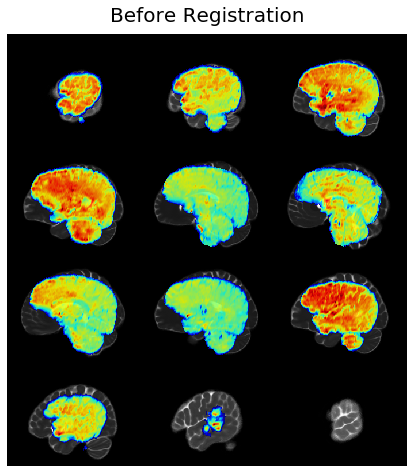

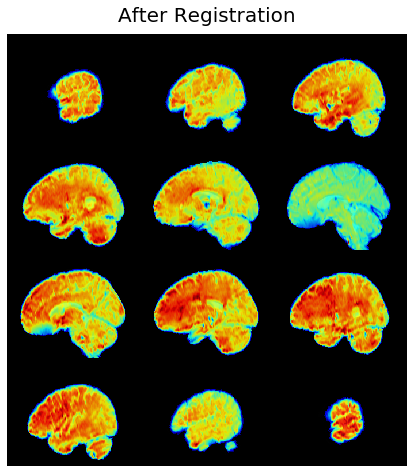

In [39]:
p2_mni = mni_template_registration(cur_path, p2)

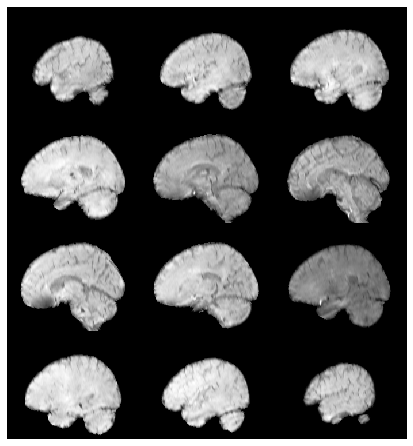

In [41]:
p2_mni.plot()